## Introducción a GANs

### Referencias
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2020. Generative adversarial networks. Communications of the ACM, 63(11), pp.139-144. [link](https://arxiv.org/abs/1406.2661)

- Creswell, A., White, T., Dumoulin, V., Arulkumaran, K., Sengupta, B. and Bharath, A.A., 2018. Generative adversarial networks: An overview. IEEE signal processing magazine, 35(1), pp.53-65. [link](https://arxiv.org/pdf/1710.07035.pdf)

### Qué pasos debemos seguir para entrenar una GAN?
- Cargar datos, transformarlos en formato necesario para pytorch. $t_{train}$ va a tener transformaciones diferentes a $t_{test}$, por qué? 
- A los datos de entrenamiento debemos dividirlos una vez mas para usar elementos de validación durante el entrenamiento.
- Definir arquitectura de nuestras redes, la red generadora ($G$), evaluadora ($D$) (Ver models.py)
- Definir métodos funciones de error, optimizador y métricas de evaluación para el entrenamiento paralelo de ambas redes.

#### Cargamos nuestros datos

In [2]:
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torchvision.utils as vutils
import PIL
import numpy as np

In [3]:
transforms_train = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0), fill=255),
    tfs.Resize((32, 32)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

transforms_test = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0), fill=255),
    tfs.Resize((32, 32)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

train_data = datasets.ImageFolder(
    "../data/train/", transform=tfs.Compose(transforms_train)
)

test_data = datasets.ImageFolder(
    "../data/test/", transform=tfs.Compose(transforms_test)
)

In [4]:
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)

##### Chequamos dispositivos disponibles para el entrenamiento

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda


#### Cómo es nuestro modelo Generador $(G)$?

In [7]:
from models.generator import _G
from models.discriminator import _D
from models.gan import GAN
import PIL.ImageOps

In [8]:
from torchsummary import summary

G = _G(input_h_w=112, latent_v=64).to(device)
summary(G, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          66,560
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
            Linear-4               [-1, 100352]     102,860,800
       BatchNorm1d-5               [-1, 100352]         200,704
              ReLU-6               [-1, 100352]               0
   ConvTranspose2d-7           [-1, 64, 56, 56]         131,136
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
  ConvTranspose2d-10          [-1, 1, 112, 112]           1,025
          Sigmoid-11          [-1, 1, 112, 112]               0
Total params: 103,262,401
Trainable params: 103,262,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00


#### Cómo es nuestro Evaluador $(D)$?

In [9]:
D = _D(input_h_w=112).to(device)
summary(D, (1, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,088
         LeakyReLU-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 128, 28, 28]         131,200
       BatchNorm2d-4          [-1, 128, 28, 28]             256
         LeakyReLU-5          [-1, 128, 28, 28]               0
            Linear-6                 [-1, 1024]     102,761,472
       BatchNorm1d-7                 [-1, 1024]           2,048
         LeakyReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 1]           1,025
          Sigmoid-10                    [-1, 1]               0
Total params: 102,897,089
Trainable params: 102,897,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.38
Params size (MB): 392.52
E

#### Cómo entrenar una GAN?

In [34]:
batch_size = 64  # Tamaño de Lote
z_dim = 64  # Dim del espacio latente
epochs = 50

In [35]:
output_dir = "output/"
PRINT_FREQ = 10
FAKE_IMG_FNAME = "fake_sample_epoch_{:04d}.png"
REAL_IMG_FNAME = "real_sample_epoch_{:04d}.png"
LOGS_FNAME = "logs.tsv"
PLOT_FNAME = "plot.svg"
SAMPLES_FNAME = "samples.svg"
CKPT_PREFIX = "networks"

##### Instanciamos ambas redes, definimos los optimizadoradores y la función de perdida

In [36]:
D = _D(input_h_w=32).to(device)
G = _G(input_h_w=32, latent_v=z_dim).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

##### Definimos las etiquetas REALES / GENERADAS

In [37]:
real_labels = torch.ones(batch_size, device=device)
fake_labels = torch.zeros(batch_size, device=device)

In [38]:
fake_labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [39]:
real_labels

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

#### Definimos la función que nos dará nuestros vectores aleatorios

In [40]:
def get_noise():
    # ruido con distribución normal
    return torch.randn(batch_size, z_dim, device=device)

In [41]:
fixed_noise = get_noise()

In [42]:
fixed_noise.shape

torch.Size([64, 64])

#### Diseñamos el entrenamiento

A diferencia de un clasificador normal, el entrenamiento de las GANs tiene algunos pasos extra, ya que el entrenamiento depende de informacion de ambas redes $(G)$ y $(D)$.

In [43]:
def step(engine, batch):
    real, _ = batch  # img, label
    real = real.to(device)

    # -----------------------------------------------------------
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    D.zero_grad()

    # Entrenamiento D con datos reales
    output = D(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

    errD_real.backward()

    # Imágenes a partir de un vector aleatorio.

    noise = get_noise()  # vector aleatorio --> Z
    fake = G(noise)

    # Entrenamiento de D con datos generados
    output = D(fake.detach())
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    errD_fake.backward()

    # Actulizar gradientes
    optimizer_D.step()

    errD = errD_real + errD_fake
    # -----------------------------------------------------------
    # (2) Update G network: maximize log(D(G(z)))
    G.zero_grad()

    output = D(fake)
    errG = criterion(output, real_labels)
    # Ahora medimos como es el error de D con datos generados
    # Otro tipo de loss: errG = 1 - (criterion(D(fake), fake_labels) + criterion(D(real), real_labels))

    D_G_z2 = output.mean().item()
    errG.backward()

    # Actulizar gradientes
    optimizer_G.step()

    return {
        "errD": errD.item(),
        "errG": errG.item(),
        "D_x": D_x,
        "D_G_z1": D_G_z1,
        "D_G_z2": D_G_z2,
    }

In [44]:
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

In [45]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook as tqdm

#### Ignite para entrenamiento de GANs

No se olviden de ver el dashboard the TensorBoard en [http://localhost:6006/](http://localhost:6006/)
Para iniciar el servidor del dashboard:

`tensorboard --logdir=./output --port 6006  --host 0.0.0.0 --load_fast=false`

In [46]:
# Definimos el Objeto 'trainer' con la función 'step'
trainer = Engine(step)

# Para ir guardando los pesos de la red mientras se entrena, debemos definir
checkpoint_handler = ModelCheckpoint(
    "weights/", CKPT_PREFIX, n_saved=100, require_empty=False
)
timer = Timer(average=True)

# Que métricas queremos seguir
monitoring_metrics = ["errD", "errG", "D_x", "D_G_z1", "D_G_z2"]
RunningAverage(output_transform=lambda x: x["errD"]).attach(trainer, "errD")
RunningAverage(output_transform=lambda x: x["errG"]).attach(trainer, "errG")
RunningAverage(output_transform=lambda x: x["D_x"]).attach(trainer, "D_x")
RunningAverage(output_transform=lambda x: x["D_G_z1"]).attach(trainer, "D_G_z1")
RunningAverage(output_transform=lambda x: x["D_G_z2"]).attach(trainer, "D_G_z2")

# Definimos el objeto TensorBoard para seguirlo a través del dashboard
now = datetime.now()
logdir = "output/" + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(log_dir=logdir, flush_secs=1)

# Definimos la barra de progreso
pbar = ProgressBar()
pbar.attach(trainer, metric_names=monitoring_metrics)

In [47]:
@trainer.on(Events.ITERATION_COMPLETED(every=PRINT_FREQ))
def print_logs(engine):
    fname = output_dir + LOGS_FNAME
    columns = ["iteration"] + list(engine.state.metrics.keys())
    values = [str(engine.state.iteration)] + [
        str(round(value, 5)) for value in engine.state.metrics.values()
    ]
    with open(fname, "a") as f:
        if f.tell() == 0:
            print("\t".join(columns), file=f)
        print("\t".join(values), file=f)
    message = f"[{engine.state.epoch}/{epochs}][{engine.state.iteration % len(train_loader)}/{len(train_loader)}]"
    for name, value in zip(columns, values):
        message += f" | {name}: {value}"

    # pbar.log_message(message)


@trainer.on(Events.EPOCH_COMPLETED(every=1))
def print_tb(engine):
    writer.add_scalars(
        "Training/Loss",
        {
            "G_error": engine.state.metrics["errG"],
            "D_error": engine.state.metrics["errD"],
        },
        engine.state.epoch,
    )


@trainer.on(Events.EPOCH_COMPLETED(every=10))
def plot_tb_fake_example(engine):
    fake = G(fixed_noise)
    grid = vutils.make_grid(fake)
    writer.add_image("Fake Images", grid, engine.state.epoch)


@trainer.on(Events.EPOCH_COMPLETED)
def save_fake_example(engine):
    fake = G(fixed_noise)
    path = output_dir + FAKE_IMG_FNAME.format(engine.state.epoch)
    vutils.save_image(fake.detach(), path, normalize=True)


@trainer.on(Events.EPOCH_COMPLETED)
def save_real_example(engine):
    img, y = engine.state.batch
    path = output_dir + REAL_IMG_FNAME.format(engine.state.epoch)
    vutils.save_image(img, path, normalize=True)


trainer.add_event_handler(
    event_name=Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"netG": G, "netD": D},
)

timer.attach(
    trainer,
    start=Events.EPOCH_STARTED,
    resume=Events.ITERATION_STARTED,
    pause=Events.ITERATION_COMPLETED,
    step=Events.ITERATION_COMPLETED,
)


# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def print_times(engine):
    # pbar.log_message(f"Epoch {engine.state.epoch} done. Time per batch: {timer.value():.3f}[s]")
    timer.reset()


# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EPOCH_COMPLETED)
def create_plots(engine):
    try:
        import pandas as pd
        import matplotlib.pyplot as plt

        plt.style.use(
            "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
        )

    except ImportError:
        warnings.warn(
            "Loss plots will not be generated -- pandas or matplotlib not found"
        )

    else:
        df = pd.read_csv(
            output_dir + "/" + LOGS_FNAME, delimiter="\t", index_col="iteration"
        )
        _ = df.plot(subplots=True, figsize=(20, 20))
        _ = plt.xlabel("Iteration number")
        fig = plt.gcf()
        path = output_dir + PLOT_FNAME

        fig.savefig(path)
        plt.close()


# adding handlers using `trainer.on` decorator API
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        create_plots(engine)
        checkpoint_handler(engine, {"netG_exception": G, "netD_exception": D})

    else:
        raise e

In [48]:
# Entrenar
trainer.run(train_loader, epochs)

# Cerramos el dashboard
writer.close()

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

[1/15]   7%|6          [00:00<?]

In [49]:
import imageio
import glob

In [50]:
lista_imagenes = [
    PIL.Image.open(x) for x in sorted(glob.glob(output_dir + "fake_*.png"))
]

In [51]:
archivo_salida = output_dir + "GAN_generate_animation.gif"
imageio.mimsave(archivo_salida, lista_imagenes, "GIF")

##### Podemos observar el progreso de la red generadora durante el entrenamiento de la GAN


<img src=output/GAN_generate_animation.gif/>

#### Evaluación de artefactos generados 
- Mostrar métricas clásicas y geométricas (FID, InceptionScore).
- Comparar test estadisticos de distribuciones de datos reales y generados.
- Usar clasificadores para datos reales.

In [52]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = tfs.ToPILImage()(img)
        pil_img = pil_img.convert("RGB")
        resized_img = pil_img.resize((128, 128), Image.BILINEAR)
        arr.append(tfs.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    real, _ = batch
    with torch.no_grad():
        noise = get_noise()
        G.eval()
        fake_batch = G(noise)
        fake = interpolate(fake_batch)
        real = interpolate(real)
        return fake, real

In [53]:
from ignite.metrics import FID, InceptionScore

In [54]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [55]:
evaluator = Engine(evaluation_step)

imgs_fake = []
imgs_reals = []


@evaluator.on(Events.ITERATION_COMPLETED(every=1))
def load_img(engine):
    global imgs_fake
    global imgs_reals
    fake, real = engine.state.output
    imgs_fake += fake
    imgs_reals += real

In [56]:
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [57]:
evaluator.run(test_loader)
metrics = evaluator.state.metrics
fid_score = metrics["fid"]
is_score = metrics["is"]

##### Inception Score

In [58]:
is_score

11.358524840028549

##### FID Score

In [59]:
fid_score

0.3101548402369632

##### Distribucion de artefactos y datos reales
Para visualizar y comparar sus distribuciones vamos a utilizar PCA

In [61]:
imgs_reals_list = [i.numpy().tolist() for i in (imgs_reals)]
imgs_fake_list = [i.numpy().tolist() for i in (imgs_fake)]
all_data = imgs_reals_list + imgs_fake_list
all_data = np.array(all_data)

In [64]:
from sklearn.decomposition import PCA

all_data = all_data.reshape(512, -1)

pca = PCA(n_components=2).fit(all_data)
Xp = pca.transform(all_data)

In [66]:
import matplotlib.pyplot as plt

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)
plt.close()
colors = np.zeros(256).tolist() + np.ones(256).tolist()

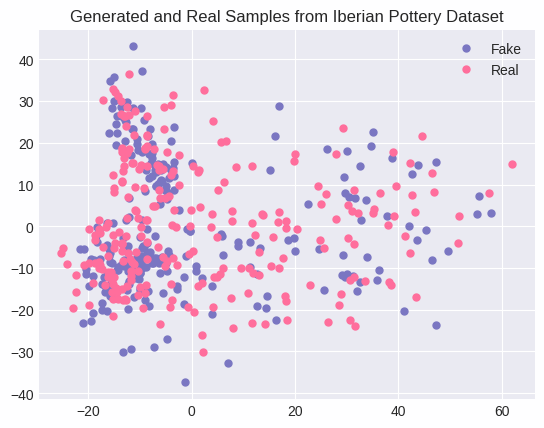

In [69]:
%matplotlib inline
import pandas as pd

name_dic = {1.0: "Real", 0: "Fake"}


pca_df = pd.DataFrame(Xp, columns=["PC1", "PC2"])
labels = pd.DataFrame([name_dic[c] for c in colors], columns=["class"])
pca_df = pd.concat([pca_df, labels], axis=1)

groups = pca_df.groupby("class")

fig, ax = plt.subplots()
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.PC1, group.PC2, marker="o", linestyle="", ms=5, label=name, alpha=1)

plt.title("Generated and Real Samples from Iberian Pottery Dataset")
ax.legend()

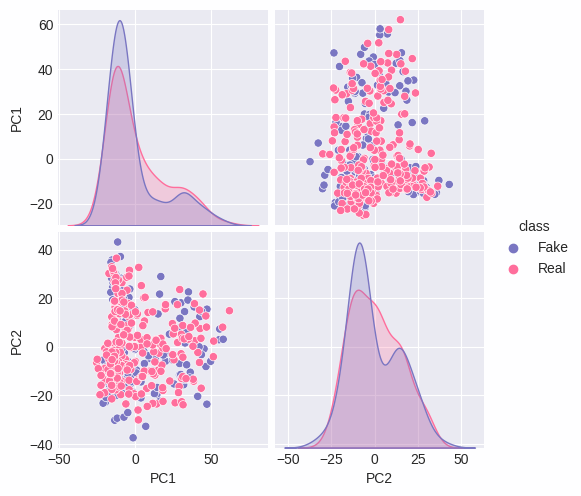

In [70]:
import seaborn as sns

sns.pairplot(pca_df, hue="class")

##### Geometric Score

In [71]:
!git clone https://github.com/KhrulkovV/geometry-score.git

Cloning into 'geometry-score'...
remote: Enumerating objects: 114, done.
remote: Total 114 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (114/114), 4.01 MiB | 6.24 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [72]:
import sys

sys.path.append("./geometry-score/")
import gs

In [73]:
all_data[all_data > 0.5] = 1
all_data[all_data < 0.5] = 0

In [74]:
y_1 = all_data[0:256]
x_1 = all_data[256:]

In [75]:
rlts_fake = gs.rlts(x_1, gamma=1.0 / 128, n=x_1.shape[0])
mrlt_fake = np.mean(rlts_fake, axis=0)

Done 0/256
Done 10/256
Done 20/256
Done 30/256
Done 40/256
Done 50/256
Done 60/256
Done 70/256
Done 80/256
Done 90/256
Done 100/256
Done 110/256
Done 120/256
Done 130/256
Done 140/256
Done 150/256
Done 160/256
Done 170/256
Done 180/256
Done 190/256
Done 200/256
Done 210/256
Done 220/256
Done 230/256
Done 240/256
Done 250/256


In [76]:
rlts_real = gs.rlts(y_1, gamma=1.0 / 128, n=y_1.shape[0])
mrlt_real = np.mean(rlts_real, axis=0)

Done 0/256
Done 10/256
Done 20/256
Done 30/256
Done 40/256
Done 50/256
Done 60/256
Done 70/256
Done 80/256
Done 90/256
Done 100/256
Done 110/256
Done 120/256
Done 130/256
Done 140/256
Done 150/256
Done 160/256
Done 170/256
Done 180/256
Done 190/256
Done 200/256
Done 210/256
Done 220/256
Done 230/256
Done 240/256
Done 250/256


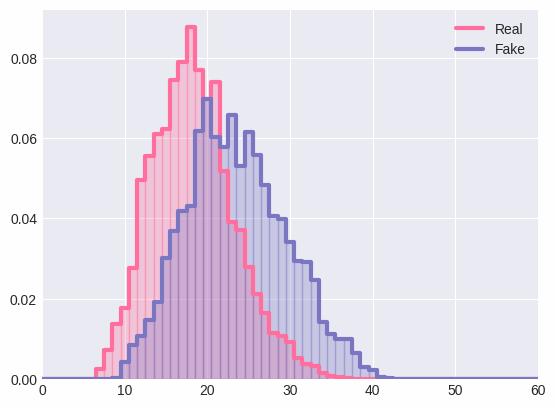

In [77]:
gs.fancy_plot(mrlt_real, label="Real", color="#ff6e9c")
gs.fancy_plot(mrlt_fake, label="Fake", color="#7a76c2")
plt.xlim([0, 60])
plt.legend()

In [78]:
print("GS-SCORE", gs.geom_score(rlts_fake, rlts_real))

GS-SCORE 0.020760914790614572


#### Podemos utilizar el clasificador entrenado, en el dia 1 para evaluar la red generadora $(G)$
- Preparamos los artefactos generados en formato  de pytorch de conjunto de imagenes
- Creamos la clase para el clasificador y cargamos los pesos entrenados
- Pasamos nuestros datos por el clasificador y observamos frequencias de distribución

In [79]:
imgs_fake_torch = torch.stack(imgs_fake)

In [80]:
transforms_test = [
    tfs.ToPILImage(),
    # tfs.RandomHorizontalFlip(p=0.7),
    # tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.ToTensor(),
]
output = torch.stack([tfs.Compose(transforms_test)(a) for a in imgs_fake_torch])

In [82]:
sys.path.append("../Day-1/.")
from models import classifier

final_classifier = classifier._C(input_h_w=64)
final_classifier.load_state_dict(torch.load("../Day-1/weights/classifier.pkl"))

In [92]:
output_class = final_classifier(output).detach().numpy()
classes = np.argmax(output_class, 1)
(unique, counts) = np.unique(classes, return_counts=True)

Text(0, 0.5, 'Frecuencia')

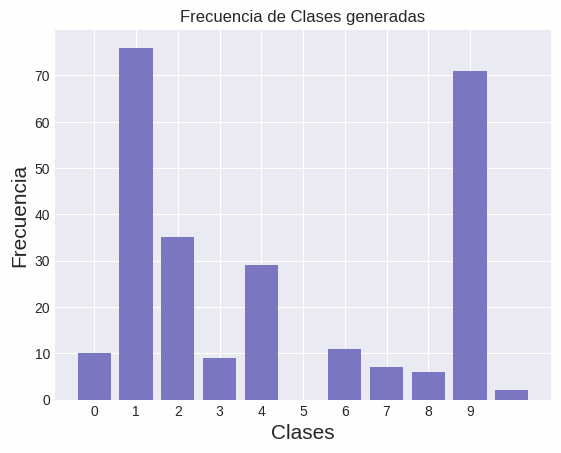

In [95]:
plt.bar(unique, counts)
_ = plt.xticks(range(0, 10))
plt.title("Frecuencia de Clases generadas")
plt.xlabel("Clases", fontsize=15)
plt.ylabel("Frecuencia", fontsize=15)

In [96]:
classes_prob = np.max(output_class, 1)

Text(0.5, 0, 'Valores')

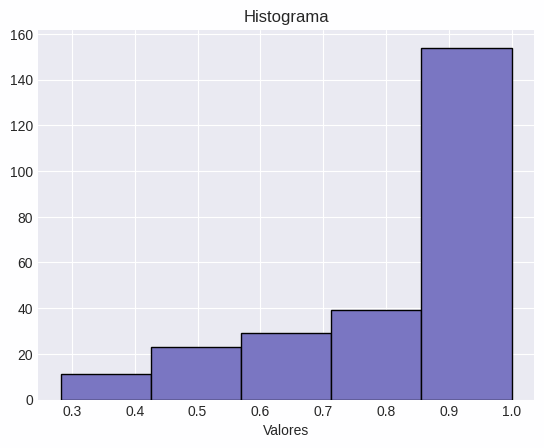

In [97]:
# Datos de ejemplo
datos = classes_prob

# Crear el histograma
plt.hist(datos, bins=5, edgecolor="black")

# Personalizar el histograma
plt.title("Histograma")
plt.xlabel("Valores")

### Ejercicios
- Ejecutar el modelo con diferentes parámetros (LRs, Loss) y comparar las métricas.
- Comparar metricas de red entrenada en 10, 50 y 100 epochs. Qué diferencias observan?.
- Extraer y visualizar ejemplos de los 5 artefactos mejor generados y peor generados con respecto a una metrica a elección.